# Case Study: Customer Clustering for Fitness-Startup

### Project Description

This project was carried out for a fitness startup (online shop supplement manufacturer) that already has an extensive customer base. The goal is to gain insights into the characteristics of the existing customers through clustering methods. These insights will be used to develop targeted strategies for increasing revenue and improving customer retention. This can be considered as the first part of the implementation of a recommender system.

The project was implemented using Python 3.11.

#  1) Library Imports

Here, all major libraries are imported first. Some individual packages are imported only when needed in the respective section.

In [1]:
import pandas as pd                
import matplotlib.pyplot as plt                              
import seaborn as sns              

# 2) Loading the Dataset

a) Loading the Dataset.

In [2]:
df_original = pd.read_csv('fitness.csv')

# Rename the columns (original column names are in german)
df_original = df_original.rename(columns={'Alter':'age', 'Geschlecht':'gender', 'Kinder': 'children', 'Raucher': 'smoker', 'Ausgaben': 'expenses', 'Region': 'region'})

# Display the first 5 rows of the dataframe
df_original.head()

,age,gender,children,smoker,BMI,expenses,region
0,19,female,0,yes,27.9,16884.92,southwest
1,18,male,1,no,33.8,1725.55,southeast
2,28,male,3,no,33.0,4449.46,southeast
3,33,male,0,no,22.7,21984.47,northwest
4,32,male,0,no,28.9,3866.86,northwest


b) Cleaning Duplicate (Rows)

In [3]:
number_of_duplicates = df_original.duplicated().sum()

df_without_duplicates = df_original.drop_duplicates()

print(f"Number of duplicates: {number_of_duplicates}")

Number of duplicates: 1


# 3) Feature Engineering

For our use case, we are primarily interested in the health status of the customers. Without missing breakdowns, the attributes of the dataset alone are insufficient to make statements about health. Therefore, the **Fitness Risk Score** (FRS) is implemented below. This metric is intended to reduce all relevant dimensions into a single value. This metric will then be used for clustering.

___

The **Fitness Risk Score** has a range of values from 0 to 10, where a higher number indicates a worse health condition (5 is neutral). The dimensions of the dataset are incorporated into the metric according to the following logic:

* **Age**: As age increases, more points are awarded depending on the threshold.

* **Children**: Due to increased stress levels, more points are awarded for more children based on the threshold.

* **BMI**: No points for normal weight, points are given for underweight and overweight.

* **Smoker**: Only smokers receive additional points.

___

For smokers, it should be specifically considered that the damage to health increases with the duration of smoking. Three models are possible for this:

* **Exponential Model**: Damage accumulates exponentially.

* **Logarithmic Model**: Decreasing marginal damage.

* **Linear Model**: Damage increases proportionally with smoking duration.

Here, a **linear model** is used for scoring, as it represents a compromise between the decreasing marginal damage of smoking over time and the declining health with increasing age. The age is used as a proxy for smoking duration.

$$\text{FRS(Smoker)} = a \cdot \text{Age} + b$$

The parameters $a$ and $c$ are chosen according to the scaling of the FRS.


a) Implementing the **Fitness-Risk-Score**.

In [4]:
from sklearn.preprocessing import MinMaxScaler

df_without_duplicates = df_without_duplicates.copy()

# Function to calculate the risk score
def calculate_risk_score(row):
    score = 0
    
    # age
    if row['age'] < 30:
        score += 0                           # No extra points for people under 30
    elif 30 <= row['age'] <= 40:
        score += 10
    elif 41 <= row['age'] <= 50:
        score += 20
    elif 51 <= row['age'] <= 60:
        score += 30
    else:  # age > 60
        score += 40                          # 40 Points for people over 60
    
    # smokers
    if row['smoker'].lower() == 'yes':
        score += row['age'] - 10             # Linear model for smokers
    elif row['smoker'].lower() == 'no':
        score += 0                           # No extra points for non-smokers
    
    # BMI
    if row['BMI'] < 18.5:                    # Underweight
        score += 10
    elif 18.5 <= row['BMI'] <= 24.9:         # Normal weight (no extra points)
        score += 0
    elif 25 <= row['BMI'] <= 29.9:           # Overweight
        score += 10
    elif 30 <= row['BMI'] <= 39.9:           # Obesity Grade I
        score += 20
    elif 40 <= row['BMI'] <= 49.9:           # Obesity Grade II
        score += 30
    else:  # BMI >= 50                       # Obesity Grade III
        score += 40
    
    # number of children
    if row['children'] == 0:                   
        score += 0                           # no extra points for no children
    elif 1 <= row['children'] <= 2:
        score += 5                           # 5 points for 1 or 2 children
    else:  # children > 2
        score += 10                          # 10 points for more than 2 children
     
    return score

# Compute the risk score for each row
df_without_duplicates.loc[:, 'Risk_Score'] = df_without_duplicates.apply(calculate_risk_score, axis=1)

# Scaling the risk score to a range from 0 to 10
scaler = MinMaxScaler(feature_range=(0, 10))
df_without_duplicates.loc[:, 'Fitness_Risk_Score'] = scaler.fit_transform(df_without_duplicates[['Risk_Score']])

# Remove the original risk score column
df_without_duplicates.drop('Risk_Score', axis=1, inplace=True)

# Display the first 5 rows of the dataframe
df_without_duplicates.head()


,age,gender,children,smoker,BMI,expenses,region,Fitness_Risk_Score
0,19,female,0,yes,27.9,16884.92,southwest,1.557377
1,18,male,1,no,33.8,1725.55,southeast,2.049180
2,28,male,3,no,33.0,4449.46,southeast,2.459016
3,33,male,0,no,22.7,21984.47,northwest,0.819672
4,32,male,0,no,28.9,3866.86,northwest,1.639344


b ) Displaying the Correlation Matrix for the Fitness Risk Score to Better Understand the Breakdown

In [5]:
corr_matrix = df_without_duplicates.select_dtypes(include=['int64', 'float64']).corr()

corr_matrix['Fitness_Risk_Score'].sort_values(ascending=False)

Fitness_Risk_Score    1.000000
age                   0.704750
expenses              0.691350
BMI                   0.417182
children              0.165236
Name: Fitness_Risk_Score, dtype: float64

**Note**: The high correlation of age arises from the linear model for smokers, which is based on age. The strong correlation with expenses comes from the strong relationship between smoking status and expenses.

Interpretation: In fact, smoking status has the greatest impact on the Fitness Risk Score.

# 4) Exploration

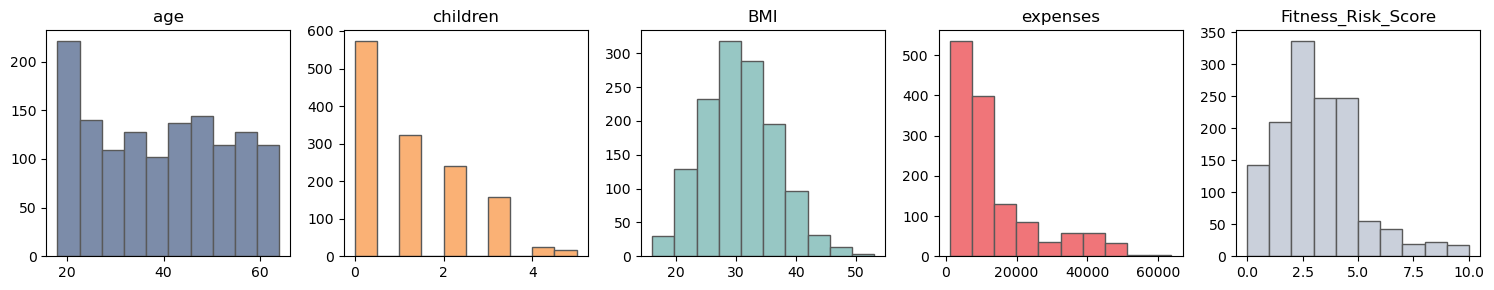

In [35]:
# Create histograms for the first 5 columns

# Define a color palette for the numerical columns
colors_vivid = {
    'age': '#7C8CA9',                # blue  
    'children': '#FAB175',           # yellow
    'BMI': '#97C7C4',                # green
    'expenses': '#F07579',           # red   
    'Fitness_Risk_Score': '#CAD0DB'  # grey   
}

# Select the first 5 columns
selected_columns = list(colors_vivid.keys())[:5]

# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the selected columns and create a histogram for each one
for ax, column in zip(axes, selected_columns):
    df_without_duplicates[column].hist(bins=10, grid=False, ax=ax, color=colors_vivid[column], edgecolor='#595959')
    ax.set_title(column)
    
plt.tight_layout()
plt.show()

**Insight**: The column 'expenses' follows a power-law distribution, which is not unusual. To analyze outliers in more detail, a boxplot of all numerical columns is generated.

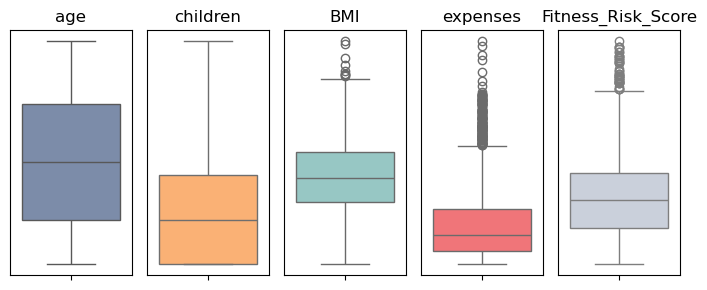

In [7]:
# Boxplot for the first 5 columns

plt.figure(figsize=(7, 3))

# Iterate over the selected columns and create a boxplot for each one
for i, (column, color) in enumerate(colors_vivid.items(), start=1):
    plt.subplot(1, 5, i)
    sns.boxplot(data=df_without_duplicates[column], color=color, saturation=1)
    plt.title(f"{column}")
    plt.yticks([])
    plt.ylabel('')

plt.tight_layout()
plt.show()

All entries above the upper whisker (1.5 times the interquartile range between the 25th and 75th percentiles) are considered outliers. However, these are neither removed nor analyzed separately, as the distributions are not overly skewed and the outliers represent relevant customer segments.

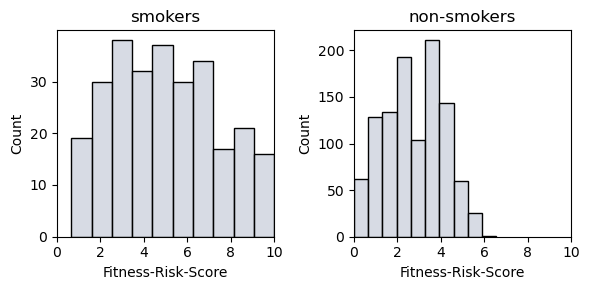

In [8]:
# Subplots for the Fitness Risk Score of smokers and non-smokers

plt.figure(figsize=(6, 3))

# Iterate over the smoker status and create a histogram for both smokers and non-smokers

for i, (smoker_status, color) in enumerate(zip(['yes', 'no'], ['#CAD0DB', '#CAD0DB']), start=1):
    plt.subplot(1, 2, i)
    sns.histplot(data=df_without_duplicates[df_without_duplicates['smoker'].str.lower() == smoker_status], x='Fitness_Risk_Score', color=color, bins=10)
    
    if smoker_status == 'yes':
        plt.title('smokers')
    else:
        plt.title('non-smokers')

    plt.xlabel('Fitness-Risk-Score')
    plt.ylabel('Count')
    plt.xlim(0, 10)
 
plt.tight_layout()
plt.show()

**Insight**: Unexpectedly, the Fitness Risk Score is approximately uniformly distributed among smokers. This suggests that not all smokers belong to a single cluster. Among non-smokers, values above 5 (the neutral element) are rarely present.

b) Creating Pivot Tables to Illustrate the Global Impact of Categorical Information.

In [9]:
# Number of unique values in each column

cat_rows = df_without_duplicates.select_dtypes(include=["object"]).columns

for row in cat_rows:
    print(df_without_duplicates[row].value_counts())
    print("-" * 25)
    

gender
male      675
female    662
Name: count, dtype: int64
-------------------------
smoker
no     1063
yes     274
Name: count, dtype: int64
-------------------------
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64
-------------------------


**Insight**: The biological genders are almost evenly distributed at 50:50, the dataset primarily consists of non-smokers, and the regions are evenly distributed except for the 'southeast'. This must be taken into account when analyzing statistics by region.

In [10]:
# Pivot table for smokers and non-smokers

pd.pivot_table(df_without_duplicates, index ='smoker',values=['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score']).round(1)

,BMI,Fitness_Risk_Score,age,children,expenses
smoker,,,,,
no,30.7,2.7,39.4,1.1,8440.7
yes,30.7,5.0,38.5,1.1,32050.2


**Insight**: The average BMI is identical for both smokers and non-smokers. This highlights that the implementation of the Fitness Risk Score provides more insightful and relevant information.

In [11]:
# pivot table for all genders

pd.pivot_table(df_without_duplicates, index ='gender',values=['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score']).round(1)

,BMI,Fitness_Risk_Score,age,children,expenses
gender,,,,,
female,30.4,3.1,39.5,1.1,12569.6
male,30.9,3.3,38.9,1.1,13975.0


**Insight**: Biological gender has no statistically significant impact.

In [12]:
# pivot table for all regions

pd.pivot_table(df_without_duplicates, index ='region',values=['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score']).round(1)

,BMI,Fitness_Risk_Score,age,children,expenses
region,,,,,
northeast,29.2,3.0,39.3,1.0,13406.4
northwest,29.2,3.0,39.3,1.2,12450.8
southeast,33.4,3.5,38.9,1.0,14735.4
southwest,30.6,3.1,39.5,1.1,12346.9


**Insight**: Since we are considering a supplement manufacturer that sells through an online shop, regional information plays a subordinate role.

# 5) Scaling

Here, a pipeline is set up to consistently scale the dataset. Clustering algorithms like K-Means rely on distance metrics that are sensitive to differing scales.

**Note**: Since the FRS is currently the only feature used for clustering, scaling is not relevant at this stage. However, the pipeline remains in place to maintain flexibility for future modifications.

**a) Building the Pipeline:**  

* **Numerical data** is scaled using sklearn's **StandardScaler** (equivalent to Z-score transformation).  

* **Categorical data** is encoded using sklearn's **OneHotEncoder** (1 if the category is present, otherwise 0).


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector

num_attribs = make_column_selector(dtype_include='number') # List with numerical columns
cat_attribs = make_column_selector(dtype_include='object') # List with categorical columns

# Create a pipeline for numerical data
num_pipeline = make_pipeline(StandardScaler()) # Scaling of the numerical data

# Create a pipeline for categorical data
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')) # One-Hot-Encoding of the categorical data

Pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), # Applying the num_pipeline on the numerical columns
    ('cat', cat_pipeline, cat_attribs)  # Applying the cat_pipeline on the categorical columns
])

b) Applying the Pipeline to the Dataset.

In [14]:
df_pipeline = Pipeline.fit_transform(df_without_duplicates)

# create a new dataframe with the transformed data and the new column names
num_columns = num_attribs(df_without_duplicates)
cat_columns = cat_attribs(df_without_duplicates)
new_columns = num_columns + list(Pipeline.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(cat_columns))
new_columns = ['z_' + col if col in num_columns else col for col in new_columns]

# Array to DataFrame
df_pipeline = pd.DataFrame(df_pipeline, columns=new_columns)

# Display the first 5 rows of the dataframe
df_pipeline.head()

,z_age,z_children,z_BMI,z_expenses,z_Fitness_Risk_Score,gender_female,gender_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.909234,-0.453484,0.297856,-0.867703,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.511647,-0.079442,0.513986,-0.954381,-0.604439,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.799350,1.580143,0.382803,-0.729373,-0.385052,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.443201,-0.909234,-1.306169,0.719104,-1.262600,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.514431,-0.909234,-0.289506,-0.777498,-0.823826,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


c ) Creating a Correlation Matrix for the Fitness Risk Score to Understand the Impact of Categorical Data.

In [15]:
corr_matrix = df_pipeline.corr()
corr_matrix['z_Fitness_Risk_Score'].sort_values(ascending=False)

z_Fitness_Risk_Score    1.000000
z_age                   0.704750
z_expenses              0.691350
smoker_yes              0.495817
z_BMI                   0.417182
z_children              0.165236
region_southeast        0.111085
gender_male             0.047553
region_southwest       -0.025483
region_northeast       -0.043755
region_northwest       -0.046129
gender_female          -0.047553
smoker_no              -0.495817
Name: z_Fitness_Risk_Score, dtype: float64

**Insight**: Here, it becomes clear that the FRS specifically addresses the attributes we are interested in.

# 6) Training & Clustering

**Choice of Clustering Algorithm**

Since only the Fitness Risk Score is currently used as the single feature for clustering, simple and easily interpretable algorithms can be applied. Therefore, the $k$-means algorithm is used here. Dimensionality reduction and scaling also specifically address the algorithm's sensitivity to outliers.
___

**Exclusion of Other Algorithms**

DBSCAN

* Well-suited for clusters with variable density or irregular shapes, but unnecessarily complex in our case.

Hierarchical Clustering

* Useful for small datasets and easily interpretable, but less efficient for larger datasets or datasets that may grow in the future and thus require recalculations (future-oriented approach).


a) Finding the Optimal $k$-Value (Number of Clusters) Based on Inertia (Elbow Plot) and the Silhouette Coefficient

c:\Users\mopo2\anaconda3\envs\3.11_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\Users\mopo2\anaconda3\envs\3.11_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\Users\mopo2\anaconda3\envs\3.11_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable 

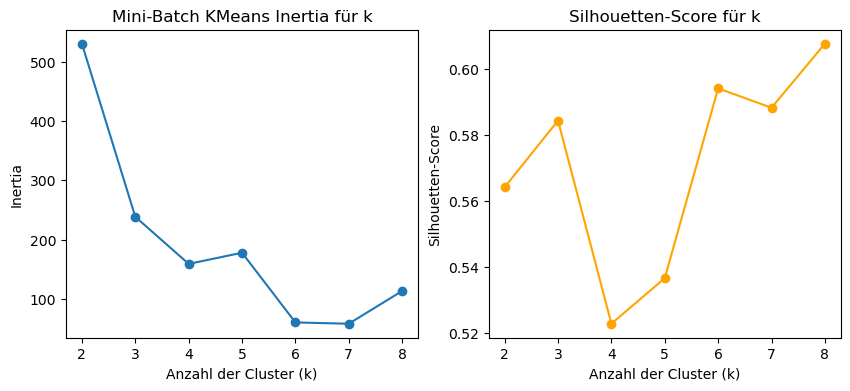

In [16]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# parameters
max_k = 8
df = df_pipeline[['z_Fitness_Risk_Score']]  # select the column for clustering

# lists for inertia and silhouette scores
inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

# MiniBatch KMeans for different k values
for k in k_values:
    mini_batch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=32, max_iter=1000, n_init=10)
    cluster_labels = mini_batch_kmeans.fit_predict(df)

    # Calculate the inertia and silhouette score for the clustering
    sil_score = silhouette_score(df, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(mini_batch_kmeans.inertia_)

# Plot the inertia and silhouette scores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Mini-Batch KMeans Inertia für k')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouetten-Score für k')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Silhouetten-Score')
plt.xticks(k_values)

plt.show()

In [17]:
best_k = 4

**Note**: The plots do not provide a clear result here. However, the number of clusters should not be determined "blindly" based on mathematical concepts, but rather aligned with the goals of the project. Therefore, the number of clusters is set to 4..

b) Clustering with the Optimal k Value.

In [18]:
final_mini_batch_kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=32, max_iter=1000, n_init=10)
final_labels = final_mini_batch_kmeans.fit_predict(df)

c:\Users\mopo2\anaconda3\envs\3.11_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


c) To improve interpretability, the cluster labels are scaled from 1 to 4 and are based on the average Fitness Risk Score of each cluster.

In [19]:
df = df_pipeline.copy()

df.loc[:, 'Cluster'] = final_labels

df_clusters = df_without_duplicates.copy()
df_clusters['Cluster'] = df['Cluster'].values


# Assign the cluster labels based on the mean Fitness Risk Score
cluster_means = df_clusters.groupby('Cluster')['Fitness_Risk_Score'].mean()

# Create a dictionary to map the old cluster labels to the new cluster labels
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_means.sort_values().index, start=1)}

# Assign the new cluster labels to the 'Cluster' column
df_clusters['Cluster'] = df_clusters['Cluster'].map(cluster_mapping)

# Display the first 5 rows of the dataframe
df_clusters.head()

,age,gender,children,smoker,BMI,expenses,region,Fitness_Risk_Score,Cluster
0,19,female,0,yes,27.9,16884.92,southwest,1.557377,1
1,18,male,1,no,33.8,1725.55,southeast,2.049180,2
2,28,male,3,no,33.0,4449.46,southeast,2.459016,2
3,33,male,0,no,22.7,21984.47,northwest,0.819672,1
4,32,male,0,no,28.9,3866.86,northwest,1.639344,2


# 7) Cluster Analysis

Different dataframes are created to illustrate the statistical metrics of each cluster. Additionally, visualizations are generated.

a ) Deciding whether the clusters should be analyzed based on the mean or median. Additionally, a color palette and other parameters are set for consistent plots.

In [20]:
method = 'mean' # mean or median

In [27]:
# Color palette for the cluster plots
cluster_palette = sns.cubehelix_palette(start=.5, rot=-.5, reverse=False, as_cmap=True)

# Global settings for the plots
Fontsize = 12

b) Creating a Pivot Table with all key metrics for each cluster.

In [22]:
df_cluster_analysis = pd.pivot_table(df_clusters, index='Cluster', values=['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score'], aggfunc=method)

# Add new columns to the pivot table
df_cluster_analysis['fraction_smoker'] = df_clusters.groupby('Cluster')['smoker'].apply(lambda x: x.value_counts(normalize=True).get('yes', 0))
df_cluster_analysis['fraction_male'] = df_clusters.groupby('Cluster')['gender'].apply(lambda x: x.value_counts(normalize=True).get('male', 0))
df_cluster_analysis['most_common_region'] = df_clusters.groupby('Cluster')['region'].apply(lambda x: x.mode().values[0])
df_cluster_analysis['fraction_most_common_region'] = df_clusters.groupby('Cluster')['region'].apply(lambda x: x.value_counts(normalize=True).max())
df_cluster_analysis['number_of_customers'] = df_clusters.groupby('Cluster')['age'].count()

df_cluster_analysis = df_cluster_analysis.round(2)

df_cluster_analysis.sort_values('Fitness_Risk_Score', ascending=True)

,BMI,Fitness_Risk_Score,age,children,expenses,fraction_smoker,fraction_male,most_common_region,fraction_most_common_region,number_of_customers
Cluster,,,,,,,,,,
1,24.50,0.77,24.07,0.69,5713.82,0.09,0.49,northeast,0.32,209
2,30.28,2.45,35.23,1.08,9591.33,0.11,0.48,southeast,0.28,613
3,33.89,4.36,49.43,1.29,16020.12,0.20,0.51,southeast,0.30,406
4,32.65,7.48,52.72,1.25,38315.12,0.99,0.61,southeast,0.39,109


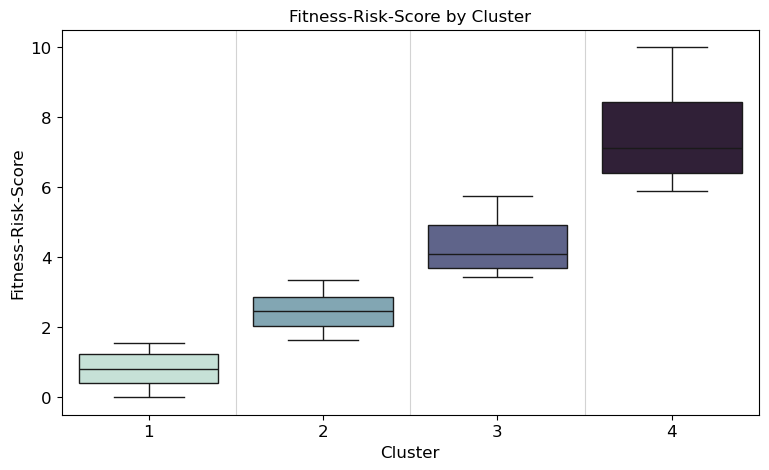

In [33]:
# Boxplot for the Fitness Risk Score of the clusters
plt.figure(figsize=(9, 5))
sns.boxplot(data=df_clusters, y='Fitness_Risk_Score', x='Cluster', palette=cluster_palette, hue = 'Cluster', legend=False)

# Add vertical lines to separate the clusters
for i in range(1, best_k):
    plt.axvline(i - 0.5, color='lightgrey', linewidth=0.8, linestyle='-')

plt.title('Fitness-Risk-Score by Cluster', fontsize=Fontsize)
plt.ylabel('Fitness-Risk-Score', fontsize = Fontsize)
plt.xlabel('Cluster', fontsize = Fontsize)
plt.xticks(fontsize=Fontsize)
plt.yticks(fontsize=Fontsize)
plt.show()

**Insight**: The classification of the clusters into FRS ranges shows no outliers and a clear division for the first three clusters, while Cluster 4 exhibits the greatest spread.

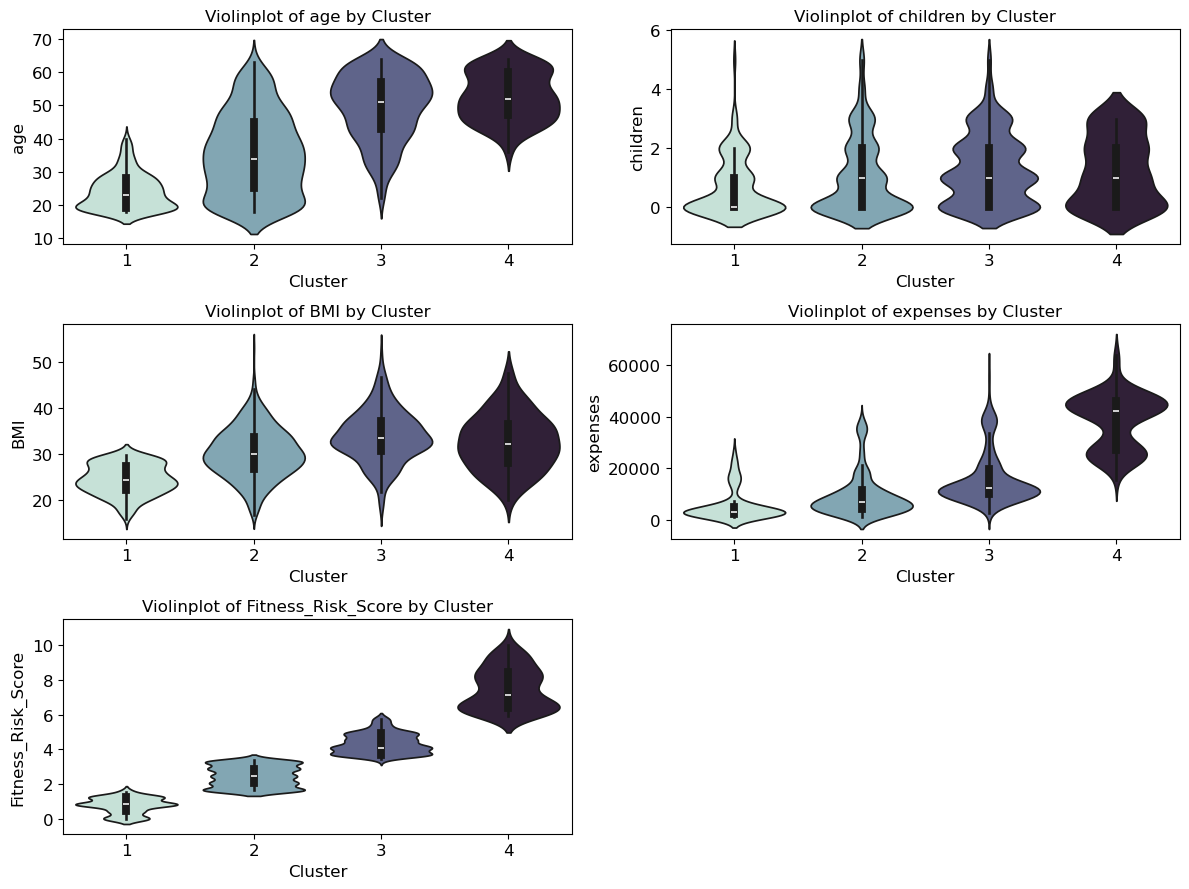

In [28]:
# Violine plots for the numerical columns
plt.figure(figsize=(12, 9))

# Iterate over the numerical columns and create a violinplot for each one
for i, column in enumerate(['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score'], start=1):
    plt.subplot(3, 2, i)
    sns.violinplot(x='Cluster', y=column, data=df_clusters, palette=cluster_palette, hue = 'Cluster', legend=False)
    plt.title(f'Violinplot of {column} by Cluster', fontsize = Fontsize)
    plt.xlabel('Cluster', fontsize = Fontsize)
    plt.ylabel(column, fontsize = Fontsize)
    plt.xticks(fontsize=Fontsize)
    plt.yticks(fontsize=Fontsize)

plt.tight_layout()
plt.show()

c ) Standard deviations of the numerical columns per cluster.

In [25]:
# Calculate the mean and standard deviation for each cluster
df_cluster_std = df_clusters.groupby('Cluster')[['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score']].std().round(2)

df_cluster_std.loc['Summe / best_k'] = (df_cluster_std.sum() / best_k).round(1)

# Add the global mean and standard deviation
df_cluster_std.loc['Global'] = df_without_duplicates[['age', 'children', 'BMI', 'expenses', 'Fitness_Risk_Score']].std().round(2)

df_cluster_std

,age,children,BMI,expenses,Fitness_Risk_Score
Cluster,,,,,
1,5.33,0.96,3.30,6042.05,0.45
2,12.21,1.28,5.42,8497.73,0.60
3,10.03,1.17,5.62,10014.81,0.58
4,7.26,1.16,6.06,10480.07,1.19
Summe / best_k,8.70,1.10,5.10,8758.70,0.70
Global,14.04,1.21,6.10,12110.36,1.87


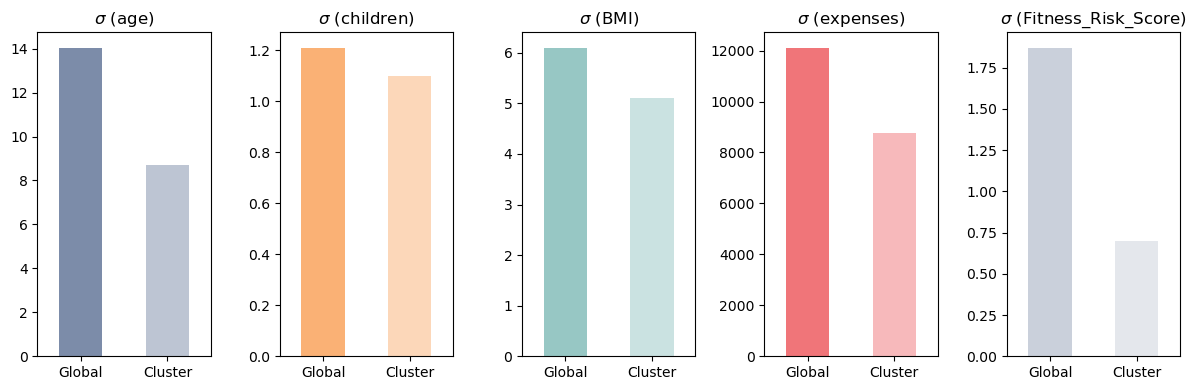

In [26]:
# Extract the last two rows of the dataframe
df_last_two_rows = df_cluster_std.iloc[-2:]

fig, axes = plt.subplots(1, len(df_last_two_rows.columns), figsize=(12, 4))

colors = [colors_vivid['age'], colors_vivid['children'], colors_vivid['BMI'], colors_vivid['expenses'], colors_vivid['Fitness_Risk_Score']]

# Iterate over the columns and create a bar plot for each one
for ax, column, color in zip(axes, df_last_two_rows.columns, colors):
    # Different alpha values for the two bars
    ax.bar(x=0, height=df_last_two_rows[column].iloc[1], color=color, alpha=1.0, width=0.5)
    ax.bar(x=1, height=df_last_two_rows[column].iloc[0], color=color, alpha=0.5, width=0.5)
    ax.set_xlim(-0.5, 1.5)
    
    ax.set_title(r"$\sigma$ (" + column + ")")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Global', 'Cluster'], rotation=0)

plt.tight_layout()
plt.show()


**Insight**: For all numerical columns, the average standard deviation of the clusters is lower than the global standard deviations. This metric can be considered a quality measure for the clustering. The Fitness Risk Score shows the largest reduction, as the clustering was based on this metric.

Since clustering is a form of unsupervised learning, there are no traditional quality criteria. The clusters found do not exist independently of the model, unlike latent factors.

Therefore, the truly relevant quality measure is not a specific metric, but rather an indicator of how well the actionable recommendations derived from the clusters can be operationalized.

## Recommendations

When deriving actionable recommendations for the individual clusters, it must be considered that the dataset consists of existing customers. Accordingly, customers from Cluster 4 are by definition unhealthy but have a strong interest in changing that (otherwise, they wouldn't be customers) → **Participation Bias**.
___

**Cluster 1: Health-Conscious Young Adults**

This customer group has a strong interest but low purchasing power. The strategy should specifically address the low purchasing power:

* Offer discounted basic bundles.

* Reward systems / tiered discounts.

* Subscription models (focus on monthly savings when the subscription model is purchased).

**Cluster 2: Millennials**

This cluster represents 60% of the customer base. With an average BMI of 30.28, it indicates Grade I obesity, and the proportion of children is higher than in the first cluster. Customers in this cluster may buy irregularly, so the strategy should focus on increasing the purchase frequency:

* Subscription models.

* Advertising for calorie-reduced substitute products.

* Advertising for supplements to support the immune system in children.

**Cluster 3: Baby Boomers**

Similar customer base to Cluster 2, but with a higher average age, increased smoking rate, and more children. The strategy should also focus on increasing purchase frequency, but with an emphasis on improving health:

* Advertising for health supplements for healthy aging.

* Advertising for calorie-reduced substitute products.

* Advertising for supplements to support the immune system in children.

* Advertising for supplements to support during menopause.

**Cluster 4: High-Risk Group**

A high-risk group with 99% smokers, high BMI, and age. This cluster is also characterized by high purchasing power. The strategy should focus on leveraging the high purchasing power and maximizing customer benefit through tailored solutions:

* Offer high-priced customized solutions.

* Consulting offers.

* Subscription models (focus on health benefits when purchased regularly).


# Limitations

Although the Fitness Risk Score is a useful and easily interpretable metric, there are certain limitations and assumptions that must be considered when interpreting the results.

___

**Limitations of the Fitness Risk Score**

* The metric reduces the dimensions of the dataset into a single value, based on subjective criteria & weightings. Therefore, correlations may be distorted, and the metric may not reflect the full complexity of the underlying data.

* Positive correlation between BMI and poor health. Without the specification of body fat percentage, muscular individuals may be incorrectly classified as less healthy.

___

**Final Thoughts**

Despite the listed limitations, the Fitness Risk Score is a meaningful metric for weighting the attributes relevant to the specific use case.